---
# Basics of Mobile Robotics Miniproject

**<center>Group 3** 
    

<center>Loïk Vuilleumier <br>
Marc Favier <br>
Michael Biselx <br>
Samuel Bumann <br>

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basics-of-Mobile-Robotics-Miniproject" data-toc-modified-id="Basics-of-Mobile-Robotics-Miniproject-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basics of Mobile Robotics Miniproject</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li></ul></li><li><span><a href="#Image-Processing" data-toc-modified-id="Image-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Image Processing</a></span><ul class="toc-item"><li><span><a href="#Detect-corner-of-the-robot's-environment" data-toc-modified-id="Detect-corner-of-the-robot's-environment-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Detect corner of the robot's environment</a></span></li><li><span><a href="#Testing-the-Module" data-toc-modified-id="Testing-the-Module-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Testing the Module</a></span></li></ul></li><li><span><a href="#Global-Map" data-toc-modified-id="Global-Map-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Global Map</a></span><ul class="toc-item"><li><span><a href="#Different-Approaches" data-toc-modified-id="Different-Approaches-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Different Approaches</a></span><ul class="toc-item"><li><span><a href="#A*-on-grid-array" data-toc-modified-id="A*-on-grid-array-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>A* on grid array</a></span></li></ul></li><li><span><a href="#Testing-the-A*-Implementation" data-toc-modified-id="Testing-the-A*-Implementation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Testing the A* Implementation</a></span></li></ul></li><li><span><a href="#Control" data-toc-modified-id="Control-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Control</a></span><ul class="toc-item"><li><span><a href="#Theory" data-toc-modified-id="Theory-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Theory</a></span><ul class="toc-item"><li><span><a href="#Estimator" data-toc-modified-id="Estimator-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Estimator</a></span></li><li><span><a href="#Control-Signal" data-toc-modified-id="Control-Signal-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Control Signal</a></span></li><li><span><a href="#State" data-toc-modified-id="State-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>State</a></span></li><li><span><a href="#Motion-Model" data-toc-modified-id="Motion-Model-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Motion Model</a></span></li><li><span><a href="#Sensor-interpretation" data-toc-modified-id="Sensor-interpretation-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>Sensor interpretation</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Setup</a></span></li></ul></li><li><span><a href="#Local-Navigation" data-toc-modified-id="Local-Navigation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Local Navigation</a></span></li><li><span><a href="#FINAL-PROGRAM" data-toc-modified-id="FINAL-PROGRAM-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>FINAL PROGRAM</a></span></li></ul></div>

## Introduction

# Image Processing
## Detect corner of the robot's environment
We want to get rid off all the random components introduced by taking a picture by hand. it's include translations, rotations, scaling and most importantly perspective transformations. Therefore we want to search four points, which we willingly place at known distances and angles from each other, to standardize our image. 

The best is to detect the four extreme angles of the rectangle environment. It's increases the precision of the transformation (smaller relative error on their distance to each other).
There are several ways to find these corner : 

- detect the lines of the rectangle (hough transform) but there will be to many line with obstacles.
- convolution with the corner pattern in the grayscale (surprisingly not efficient at all) advantage of being scale invariant but not at all rotation invariant
- convolution with specific pattern in the full color range (i.e. a pattern with a very specific color, easier to find) we chose a disk because it's rotation invariant the most important criter for convolution (not scale invarient but it's ok). by being the only object of a specific color in the plan it's supposed to be very easy to find but still some difficulties.

We chose the last option, the more efficient 

In the following code we use the HSV representation to find the four blue corner and from them transform the image. Next we look for the orientation of the robot with the two red disk (two because we want position and orientation). Next we find the goal position with the green circle. And finally we determine a smaller version, binarized and with bit expnaded obstacles of the map to apply path finding.

Here we import libraries which define usefull functions and variables. 
The [Vision](src/Vision.py) module is the one written specifically for this project.  

In [1]:
#!pip install scikit-image  # used inside the Vision module

In [2]:
import os
import sys
import cv2
import numpy as np

# Adding the src folder in the current directory as it contains the Vision module
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
import Vision as vis

In [3]:
def camera_thread(cap, camera_pos) : 
    """ do the camera position acquisition cycle """
    
    x = np.array([])
    while not x.size :
        success, img = cap.read()                                  # read the image from the fixed camera
        if success :
            true_map     = vis.get_clean_map(img, [1200, 800])     # get the clean in good resolution
            x            = vis.robot_detection(true_map)           # find the robot
        time.sleep(.1)
    
    camera_pos.x = x.copy()

## Testing the Module
The following cell allows the testing of the setup, independently of other modules.

In [4]:
#cap_size  = (1200, 1000)
#map_shape = [1200,  800]
#cap       = cv2.VideoCapture(1)                       # put 1 if an external webcam is used
#cap.set(cv2.CAP_PROP_FRAME_WIDTH, cap_size[0])        # width
#cap.set(cv2.CAP_PROP_FRAME_HEIGHT,cap_size[1])        # height
#cap.set(cv2.CAP_PROP_AUTO_EXPOSURE,1)                 # set auto exposure

#while True :
#    success, img = cap.read()
#    if success :
#        true_map = vis.get_clean_map(img, map_shape)              # get a clean map
#        obs_map = vis.get_global_search_map(true_map)             # find obstacles
#        robot_pos, true_map = vis.robot_detection(true_map, True) # find the robot, annotate on map
#        goal_pos,  true_map = vis.goal_detection(true_map, True)  # find the goal, annotate on map
#        cv2.imshow("Raw", img)                                    # display
#        cv2.imshow("Map", true_map)
#        cv2.imshow("Obstacles", obs_map)
#    else:
#        print("Couldn't capture image")
#        break
#
#    if (cv2.waitKey(1) & 0xFF) == ord('q'):                       # quit when 'Q' key is pressed
#        break

#cap.release()
#cv2.destroyAllWindows()

# Global Map

## Different Approaches
Different approaches exist to find an optimal global path. In the beginning a visibility graph was considered. To find the shortest path from start to goal Dijkstra’s algorithm was used. Due to difficulties in detecting the corners of the objects a new approach had to be found. 
Therefore a cell decomposition/grid based approach was implemented.

### A* on grid array
To find the optimal path from the start to end position, the A* algorithm is used on a binary grid array. The A* algorithm can be seen as an extension of Dijkstra's algorithm. The grid array represents free spaces with a zero and obstacles (which the robot has to navigate around) with a one. For the implementation, a modified version of the code from the Exercise session 5 of the course MICRO-452  “Basics of Mobile Robotics” was used.
The code can be found in the [PathPlanning](src/PathPlanning.py) module.

> <img src="./imgs/global_path_test.png" />

> *Figure 1: ...*

In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Adding the src folder in the current directory as it contains the PathPlanning module
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
import PathPlanning

## Testing the A* Implementation
Following cell allows the testing of the A* allgorithm on a binary grid array, without needing all the setup (robot and surrounding).

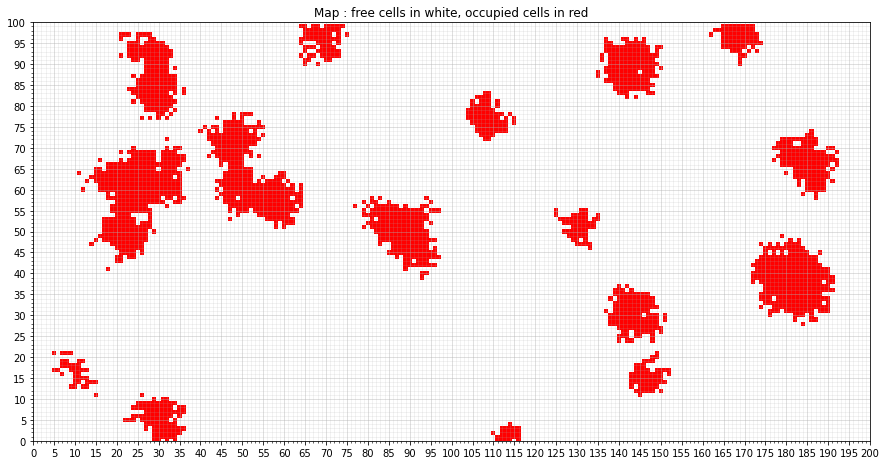

In [11]:
#max_val_column = 200 # Size of the map
#max_val_row=100
#occupancy_grid, cmap=PathPlanning.create_random_occupancy_grid(max_val_column, max_val_row)

path (form start to goal)
x=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
y=[ 0  1  2  3  4  5  6  7  8  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 31 3

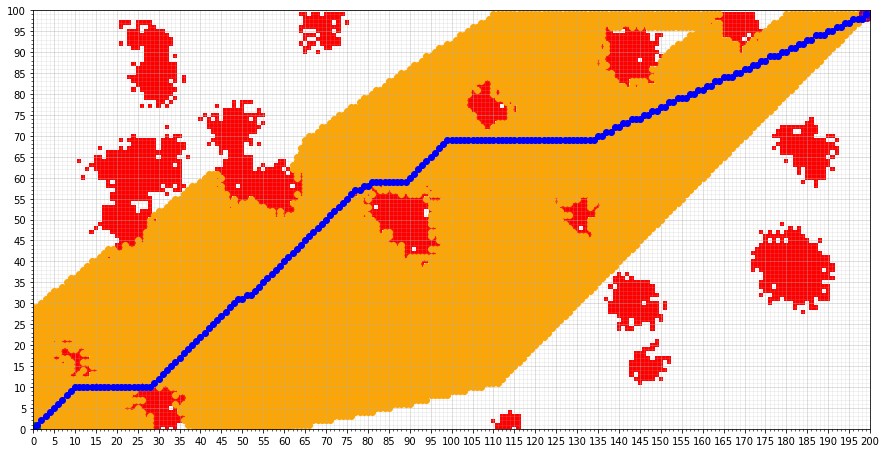

In [12]:
## Define start and end goal -> values have to be changed, that the are on empty spot and that a path between them exists
# test_start=(0,0)    #value has to be changed
# test_goal=(99,199)  #value has to be changed
# path=PathPlanning.generate_global_path(test_start, test_goal, occupancy_grid)
# path=np.fliplr(path)
# print(f"path (form start to goal)")
# print(f"x={path[1]}")
# print(f"y={path[0]}")

# Control

## Theory
Once the path planning has been done, we need to get the Thymio robot to follow the planned path.
We do so by implementing a pilot, which uses knowledge of the robot's location relative to its next goal to calculate the motor inputs necessary to reach this goal. 

Unfortunately, the robot does not always have perfect knowledge of its position at all times, so it must be estimated from the limited measurements it does have access to, namely
- motor odometry
- ground IR sensors 
- horizontal proximity sensors

Because both the movement process and these measurements are quite noisy, simply dead reckoning the robot's position is not accurate enough. We need to implement a stochasitc state estimator to try to estimate the robot's position from the noisy measurements.

> <img src="./imgs/control-Page-1.png" />

> *Figure 1: Control diagram of the robot and pilot*

### Estimator
A number of stochastic estimation methods exist. The approach chosen in this project, the Kalman Filter, is computationally one of the simplest. It was chosen in the hopes of making the system more reactive. The Kalman filter is normally used for systems with linear behavior, but it can relatively easily be extended to non-linear systems that do not vary too abruptly:
$$ \begin{eqnarray}
\bar{\mathbf x} &=& g(\hat{\mathbf x}, \mathbf u)\\
\bar{s} &=& G_{\mathbf x,\mathbf u}\cdot s\cdot G_{\mathbf x,\mathbf u}^T\\
K       &=& \bar{s}\cdot C^T\cdot (C\cdot\bar{s}\cdot C^T + R)^{-1}\\
\hat{\mathbf x} &=& \bar{\mathbf x} + K(\mathbf y-C\bar{\mathbf x})\\
s       &=& (I - K C)\cdot \bar{s}
\end{eqnarray}$$

### Control Signal
The Thymio robot may be controlled throught its two motors. Our control signal $\mathbf u$ will therefore be : 
$$ \mathbf u = \begin{bmatrix} u_r\\ u_l \end{bmatrix}$$

### State 
The state of the robot $\mathbf x$ is defined as follows :
$$ \mathbf{x} = \begin{bmatrix}x\\ y \\ \phi \\ v_r \\ v_l\end{bmatrix}$$
where $[x , y]^T$ are the robot's position in space, $\phi$ is its angular orientation with respect to the x-axis, and $[v_r , v_l]^T$ are the speed on the right and left wheels, respectively. 

### Motion Model
To apply the extended Kalman Filter, we need to define a motion model $\mathbf x^{+} = g(\mathbf{x,u})$. 
The simplest motion model for a robot such as the Thymio can be calculated in two steps. First, the intermediary values describing the change in angle and in distance are calculated:  
$$ \begin{bmatrix}dl\\ d\phi\end{bmatrix} = B\cdot \mathbf u , \text{ for  } B=c \cdot T_s\begin{pmatrix} 0.5 & 0.5 \\  \frac{1}{d} & -\frac{1}{d} \end{pmatrix} $$ 

where $T_s$ is the sample time and $d$ is the distance between the wheels. $c$ is a conversion constant to convert between Thymio speed and $mm/s$. 
Then the actual states may then be approximated as:
$$\begin{eqnarray}
\phi^{+} &=& \phi + d\phi\\
x^{+}    &=& x + dl \cdot cos(\phi^{+})\\
y^{+}    &=& y + dl \cdot sin(\phi^{+})\\
v_r^{+}  &=& u_r\\
v_l^{+}  &=& u_l
\end{eqnarray}$$
Other motion models were studied, and can be found in the module code.

In order to linearize the motion model for use in the Kalman filter, we must calculate its Jacobian. This can be done analytically, but it is too tedious for this report. The result can be found in the code for this module. 
$$G_{\mathbf{x,u}} = \begin{bmatrix} 
\frac{\partial g}{\partial x}(\mathbf{x,u}) &
\frac{\partial g}{\partial y}(\mathbf{x,u}) & 
\frac{\partial g}{\partial \phi}(\mathbf{x,u}) & 
\frac{\partial g}{\partial v_r}(\mathbf{x,u}) & 
\frac{\partial g}{\partial v_l}(\mathbf{x,u}) 
\end{bmatrix}$$



Finally, we must estimate the uncertainty added by an update step of the motion process. We can measure the uncertainty on the motion process by wheel, which gives us $\mathbf{q} = \begin{bmatrix} q_r \\ q_l \end{bmatrix}$ resulting in a coviariance matrix $Q_{\mathbf u}$ with diagonal $\mathbf{q}$.
We can then apply the propagation of covariance formula though the linearized system (the Jacobian $G_{\mathbf{x,u}}$) in order to estimate the uncertainty on the robot state gained due to noise for a single process step:
$$ Q = G_{\mathbf{x,u}} \begin{pmatrix} \mathbf 0 & 0 \\ 0& Q_{\mathbf{u}}\end{pmatrix} G_{\mathbf {x,u}}^T$$
**Note:** This is in fact illegal. The real probablity density of the error added to the robot's state is highly non-linear. It follows a banana-shape, as the anguar uncertainty is much larger than the distance uncertainty. However, it was estimate(d) that the robot would have ample chance to localize itself and thus reduce the uncertainty to a level where the non-linearity doesn't matter as much.


### Sensor interpretation 

As mentioned above, the robot has access to several sensors which give it information about the world surrounding it. 
In our application, the sensors available to us do not allow a reversible mapping into state-space (i.e: the sensor function $\mathbf y = h(\mathbf x)$ is non-invertible). This is because the map is made up of a repeating grid, so we have no information on the absolute localization, and furthermore from the pont of view of the sensor, there is no way to tell whether the detected line is horizontal or vertical.
We must therefore do a preprocessing step on the raw sensor values to put them into a useable form for our (over)extended Kalman estimator.

A first approach was, whenever a line was detected by a sensor to simply take the coordinate of the closest gridline to the estimated position of that sensor as the "measured value" $\tilde{\mathbf y}$. This approach however does not take into account the fact that the estimated postion of the robot can be quite uncertain, so the returned "measured values" are very often wrong.

A different approach is to incorporate our estimated uncertainty into the sensor interpretation. Instead of looking for the closest gridline, we look for the most likely coordinates in which we could encounter a gridline, as shown in figure 3 below. These are then taken as $\tilde{\mathbf y}$.
This approach was adapted from the paper : https://www.cs.cmu.edu/~motionplanning/papers/sbp_papers/integrated2/machler_grid_odometry.pdf

> <img src="./imgs/pdf-based_lacation_estimate.png" alt="pdf-based_lacation_estimate" style="width: 200px;"/>

> *Figure 2 : PDF-based location estimation. The real position of the sensor in space is unkown, so it is modelled as multivariate gaussian probability density function. When a gridline is encountered, we can calculate the position on the gridlines with the highest probablilty, and take this as our new position estimate.*

## Setup

The code for this module can be found under [Robot.py](src/Robot.py), and some generic-use code can also be found in [util.py](src/util.py) and [Field.py](src/Field.py).
The code for creating [threads](src/RepeatedTimer.py) was adapted from code presented in the course MICRO-452 “Basics of Mobile Robotics” 

Below, we define the thread which controls the robot. 

In [7]:
import os
import sys
import time
import serial
import numpy as np
import matplotlib.pylab as plt
from IPython import display as ds

# Adding the src folder in the current directory as it contains the necessary scripts
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio
import RepeatedTimer
import Field
import Robot
import util

In [8]:
def robot_thread(field, robot, goals, camera_pos):
    """ do the robot control cycle """

    if not goals :
            raise Exception("No more goals")   #this is bad, but i'm no python expert, so it'll have to do
            return 

    u,local_obstacle = robot.pilot(goals)

    if not local_obstacle :
        robot.do_motion(u)

    sensor_data = robot.do_measure()
    
    if local_obstacle : 
        u = sensor_data[9:11,:]
        u[u>2**15] = u[u>2**15] - 2**16

    y = robot.sensor_interpretation(sensor_data, field)

    if camera_pos.x.size :                                    # if a camera position is available, update
        c0 = np.concatenate((np.eye(3), np.zeros((3,2))), axis = 1)
        y0 = camera_pos.x[0:3,:]
        r0 = np.array([.5, .5, .05])**2                      # we assume the camera position is the most precise 
        robot.R = np.diag(np.concatenate((r0, np.diag(robot.R)), axis=0)) # possible to make our lives simpler 
        robot.C = np.concatenate((c0, robot.C))
        y       = np.concatenate((y0, y), axis=0)
        field.xreal  = np.concatenate((field.xreal, camera_pos.x), axis=1)
        camera_pos.x = np.array([])

    xtemp, stemp = robot.kalman_estimator(u, y)

    robot.xodo = robot.motion_model(robot.xodo, u)             # make a purely odometry-based estimate, for comparison

    field.xhat  = np.concatenate((field.xhat, xtemp), axis=1)
    field.xodo  = np.concatenate((field.xodo, robot.xodo), axis=1)
    field.s.append(2*np.sqrt(stemp[0,0]+stemp[1,1]))  

# Local Navigation

The local navigation is programmed with Aseba and is thus running on the Thymio itself. This allows a quick reaction to local obstacles, because the data must not to travel to the computer and back.

The goal of the local navigation is to follow alongside the obstacle until the robot is back onto its global path.

To follow the obstacle, mainly the outer infrared (IR) sensors of the Thymio are used, because they are the only sensors that return non-zero values when the Thymio is parallel to the obstacle. Furthermore, only the speed of the wheel which is further away from the obstacle is usually changed. The speed of the wheel which is closer to the obstacle is mostly constant. An exception is made when at least one of the three middle IR sensors returns a non-zero value, which means that the robot is not parallel to the obstacle anymore. In this case the speed of both wheels are reduced, to avoid a collision with the obstacle.

The speed of the wheel which is further away from the obstacle is controlled by a simple proportional controller. This means that the speed of this wheel is proportional to the error (difference between the desired sensor value and the real sensor value). 

In Aseba, a timer emits an event every 200ms. At each of these events the speed of the closer wheel to the wall is updated, in order to avoid the obstacles. To determine the speeds of the two wheels, first it is determined if the obstacle is located on the left or right side of the robot. Then the speeds are calculated based on the sensor values and the proportional gain. Finally the speed target values of the Thymio are updated with the calculated speeds.

The Python and the Aseba programs have to communicate with each other, to prevent that both programs interfere with each other by giving contradictory commands. For this purpose the "event.args" variables, which are available for both programs, where used. The variable "event.args[0]" describes if the robot is in global or local navigation. This considered by both, Python and Aseba, such that only one program gives commands to the robot.

To switch from global to local navigation, "event.args[0]" is changed in Aseba, if a local obstacle is detected with the IR sensors. Furthermore, the flag “event.args[0]” determines if the Python or the Aseba program controls the robot.

It is a bit harder to switch from global to local navigation. As seen in the course there are multiple solutions to this problem. The chosen solution consists of exiting local navigation if the robot gets back to the global path, as mentioned above. 
Since the global path is described by close points, the robot can be considered to be on the global path, if it is next to such a point. In this case the robot can continue with the global navigation, but it has to ignore the IR sensors for a moment to avoid getting back into local navigation instantly. However, then the possibility exists that the robot collides with the obstacle while ignoring the IR sensors. The solution implemented to solve this issue, is to assure that the next point of the global navigation and the obstacle are on opposite sides of the robot. This way the robot can exit the local navigation without hitting the obstacle. 

A challenge encountered during the implementation of the local navigation was the robot turning early around the corner and bumping into it with its rear part. This is because the IR sensors are directed forward and that one wheel has a constant speed. The solution implemented to solve this problem is to delay the turning, when the obstacle is not detected by the sensors anymore. This is not an ideal solution but it is functional.

# FINAL PROGRAM

In [9]:
robot      = Robot.NewRobot()                                                   # robot 
field      = Field.NewField(1200, 800, 200, 4)                                  # table

robot.th   = Thymio.serial(port="COM15", refreshing_rate=0.1)                   # set up Thymio communication

arrived


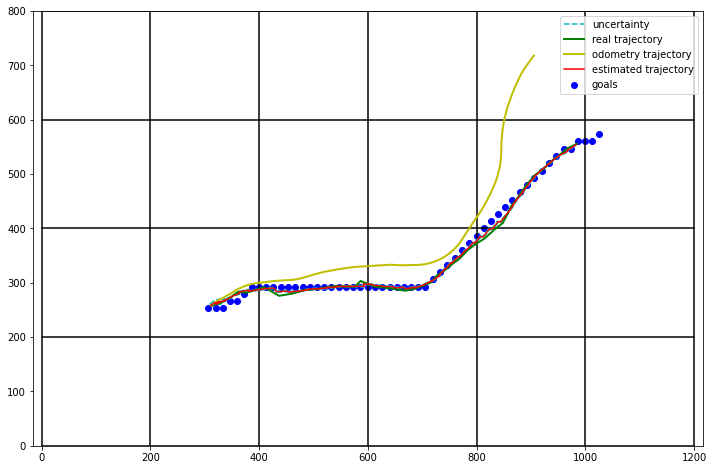

Exception in thread Thread-7:
Traceback (most recent call last):
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\Michael Biselx\Desktop\MobRob\basics-of-mobile-robotics\src\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "c:\users\michael biselx\appdata\local\programs\python\python38-32\lib\site-packages\serial\serialwin32.py", line 323, in write
    raise writeTimeoutError
serial.serialutil.SerialTimeoutException: Write timeout


In [10]:
#################################################################################
# setup vision
#################################################################################
cap_size          = (1200, 1000)
global_shape      = (90,  60)
cap               = cv2.VideoCapture(1)                                         # put 1 if an external webcam is used
cap.set(cv2.CAP_PROP_FRAME_WIDTH, cap_size[0])                                  # width
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,cap_size[1])                                  # height
#cap.set(cv2.CAP_PROP_AUTO_EXPOSURE,1)                                           # set auto exposure
#time.sleep(1)

startpos = np.array([])
end_pos  = np.array([])
while not startpos.size or not end_pos.size:
    success, img  = cap.read()
    if success : 
        true_map  = vis.get_clean_map(img, [field.xmax, field.ymax])
        startpos  = vis.robot_detection(true_map)                                # try until we get valid positions
        end_pos   = vis.goal_detection(true_map)   
    else :
        print("No image captured")
    time.sleep(.1)   

cv2.imshow("True Map", true_map)
cv2.waitKey(0)

#################################################################################
# global path finding
#################################################################################
map_global_search = vis.get_global_search_map(cv2.resize(true_map, global_shape))# apply resizing to reduce computation cost of global search
map_start         = util.rescale_int_coords(startpos, (true_map.shape[1], true_map.shape[0]), global_shape)  # starting point for global search
map_end           = util.rescale_int_coords(end_pos,  (true_map.shape[1], true_map.shape[0]), global_shape)  # end point for global search

occupancy_grid    = np.flipud(np.asarray(map_global_search))                     # make occupancy grid and change coordinate system           
path              = PathPlanning.generate_global_path((map_start[1], map_start[0]), (map_end[1], map_end[0]), occupancy_grid)
path              = util.adapt_pathfinder_coords(path, field, occupancy_grid.shape)

#################################################################################
# setup robot 
#################################################################################
Tr = .2                                                                          # robot update timestep
Tc = 4                                                                           # camera update timestep

robot.xhat  = startpos.copy()                                                    # setup robot
robot.xodo  = startpos.copy()
robot.s     = np.diag([1, 1, .1, 20, 20])**2

#robot.d     = 90
robot.set_Ts(Tr)
robot.maxv  = 10
robot.maxw  = np.pi/16

field.goals = path
field.xreal = startpos.copy()                                                    # prepare record of (mis)deeds
field.xhat  = robot.xhat.copy()
field.xodo  = robot.xodo.copy()
field.s     = [2*np.sqrt(robot.s[0,0]+robot.s[1,1])]

goals       = np.ndarray.tolist(field.goals)

class Camera_Pos :
    def __init__ (self): 
        pass
camera_pos   = Camera_Pos()
camera_pos.x = np.array([])                                                      # communication variable


#################################################################################
# run
#################################################################################
T = 60                                                                           # maximum run time allowed

rt = RepeatedTimer.Thread(Tr, robot_thread,  field, robot, goals, camera_pos);   # start threads
ct = RepeatedTimer.Thread(Tc, camera_thread, cap, camera_pos);

try:
    for i in range(T):
        time.sleep(1) 
        plt.clf();
        plt.gcf().set_size_inches(12,8)
        plt.imshow(occupancy_grid,cmap=colors.ListedColormap(['white', 'black']), origin = 'lower', extent=(field.xmin, field.xmax, field.ymin, field.ymax))
        field.plot()
        ds.display(plt.gcf())
        ds.clear_output(wait=True)
        
        if not goals : 
            print("arrived")
            break

finally:
    rt.stop()
    ct.stop()
    robot.th.set_var("event.args", 2)
    robot.do_motion(np.zeros((2,1)))

In [ ]:
ct.stop()

In [ ]:
tr.stop()

In [ ]:
robot.do_motion(np.zeros((2,1)))
robot.th.close()